*Prepared for the course "TDPS22: Data Science Programming" at Jönköping University, Teacher: [Marcel Bollmann](mailto:marcel.bollmann@ju.se)*

# Exercise 10: Statistical Modeling

This notebook contains exercises on statistical modeling in R, focusing on very basic modeling with core R functionality, R's formula syntax, as well as a basic introduction to the Tidymodels ecosystem.  In the end, I also include pointers for how to do some of the more advanced things we did in the Python exercises.

### Learning Goals

- Understand how to _compute, visualize, and evaluate_ simple statistical models in R.
- Know the basics of _R's formula syntax._

### Useful Resources

This exercise doesn't follow the book as closely as the previous ones, but takes inspiration from the following sources:

+ [§23 "Model basics" in _R for Data Science_](https://r4ds.had.co.nz/model-basics.html)
+ ["Get Started" guide from _Tidymodels_](https://www.tidymodels.org/start/)
+ [R Graphics Cookbook](https://r-graphics.org/)
+ [RStudio Cheatsheets](https://www.rstudio.com/resources/cheatsheets/)

- - -

## Extra packages

For parts of this exercise, we'll be using [Tidymodels](https://www.tidymodels.org/) and [ranger](https://www.rdocumentation.org/packages/ranger/versions/0.13.1/topics/ranger).  **I suggest installing them in a separate R session while you work on the first parts of the exercise, as they can take a while to download & install!**

- If you get errors during installation, check if specific packages cause the error. On my system, I had to explicitly re-install `pillar` before I could install `tidymodels` successfully.
- If you get errors attaching the new packages (e.g. after `library(tidymodels)`), try restarting the R kernel and load everything again.

In [1]:
#install.packages("tidymodels")
#install.packages("ranger")

In [2]:
library(tidyverse)
library(modelr)
library(palmerpenguins)
penguins <- drop_na(penguins)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



- - - 

## Correlation

Let's start with computing and visualising correlations on the penguins dataset, which we've also seen in the Python exercises. We don't follow the book directly here, although it briefly touches on this in [§7.5](https://r4ds.had.co.nz/exploratory-data-analysis.html#covariation).

**1. Compute the Pearson correlation between `bill_length_mm` and `bill_depth_mm`!** Look up the documentation for `cor()` to find out how to do this. Try to do it in at least two ways: (i) calling `cor()` directly on the data; and (ii) using it in a pipe together with `summarise()`. What's the difference between these two approaches?

In [3]:
# We can call cor() directly by just giving the two column vectors as arguments:
# (note that "Pearson" is the default correlation method)
cor(penguins$bill_length_mm, penguins$bill_depth_mm)

[1] -0.2286256

In [4]:
# The pipe approach could be used as part of a larger data transformation.
# The result is a 1x1 tibble:
penguins %>% summarise(cor = cor(bill_length_mm, bill_depth_mm))

cor
<dbl>
-0.2286256


**2. Compute the _pairwise_ Pearson correlation between all four numeric variables!** In Exercise 5, Q7, we did this with a single call to `pingouin.pairwise_corr()`. How can we get something similar with R? Produce a tibble that looks similar to this:

| **X**              | **Y**               | **cor**    |
|:-------------------|:--------------------|-----------:|
| bill_length_mm     | bill_length_mm      |  1.0000000 |
| bill_length_mm     | bill_depth_mm       | -0.2286256 |
| bill_length_mm     | flipper_length_mm   |  0.6530956 |
| ...                | ...                 | ...        |

_Notes:_

- `cor()` can work with more than two variables!
- Since `cor()` returns a "matrix", not a "tibble", you might want to look at `as_tibble(rownames = ...)` to convert it to one.


In [5]:
# Calling cor() on all 
(cormatrix <- penguins %>% select(bill_length_mm:body_mass_g) %>% cor)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.0000000,-0.2286256,0.6530956,0.5894511
bill_depth_mm,-0.2286256,1.0000000,-0.5777917,-0.4720157
flipper_length_mm,0.6530956,-0.5777917,1.0000000,0.8729789
body_mass_g,0.5894511,-0.4720157,0.8729789,1.0000000


In [6]:
# Convert to tibble and pivot to get the desired format:
(cortibble <- as_tibble(cormatrix, rownames = "X") %>%
    pivot_longer(
        -X,
        names_to = "Y",
        values_to = "cor"
    ))

X,Y,cor
<chr>,<chr>,<dbl>
bill_length_mm,bill_length_mm,1.0000000
bill_length_mm,bill_depth_mm,-0.2286256
bill_length_mm,flipper_length_mm,0.6530956
bill_length_mm,body_mass_g,0.5894511
bill_depth_mm,bill_length_mm,-0.2286256
bill_depth_mm,bill_depth_mm,1.0000000
bill_depth_mm,flipper_length_mm,-0.5777917
bill_depth_mm,body_mass_g,-0.4720157
flipper_length_mm,bill_length_mm,0.6530956


**3. Produce a _heat map_ that shows the Pearson correlation between all four variables, with _negative_ and _positive_ values in different colors.** The table you produced in the previous task is the ideal starting point for this. With this, you should be able to:

- Plot a heat map. We haven't seen how to do this yet, but a good place to look it up is the [R Graphics Cookbook](https://r-graphics.org/) (there's also an example in the _R for Data Science_ book).
- Change the color palette. Correlations, where we want to distinguish between _positive_ and _negative_ values by color, are a prime use case for _divergent_ color palettes. Refer back to [§28](https://r4ds.had.co.nz/graphics-for-communication.html#scales) and the previous exercise, and find an appropriate divergent color palette for the heat map.
- _Bonus:_ How can we make sure the color palette goes from -1 to +1, so the middle is exactly at 0? (The keyword here is "limits".)
- _Bonus:_ How can we also plot the numeric values inside the heatmap?

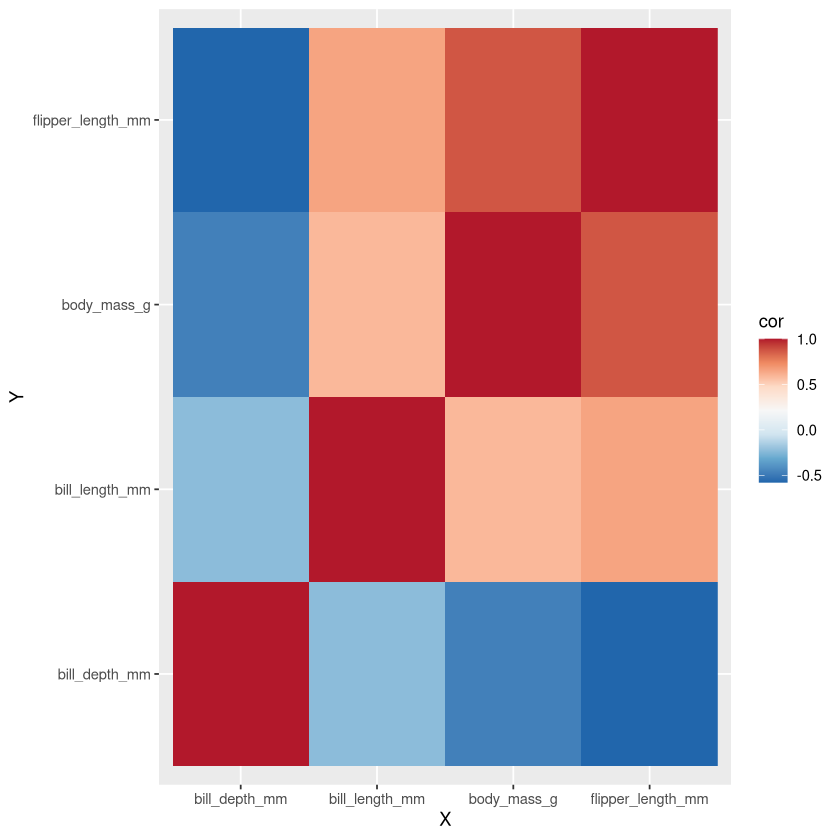

In [7]:
# - We can use geom_raster (or geom_tile) as per https://r-graphics.org/recipe-miscgraph-heatmap
# - We need a "fill" scale for "continuous" variables, so scale_fill_distiller() is an option.
ggplot(cortibble) +
    geom_raster(aes(X, Y, fill = cor)) +
    scale_fill_distiller(palette = "RdBu")

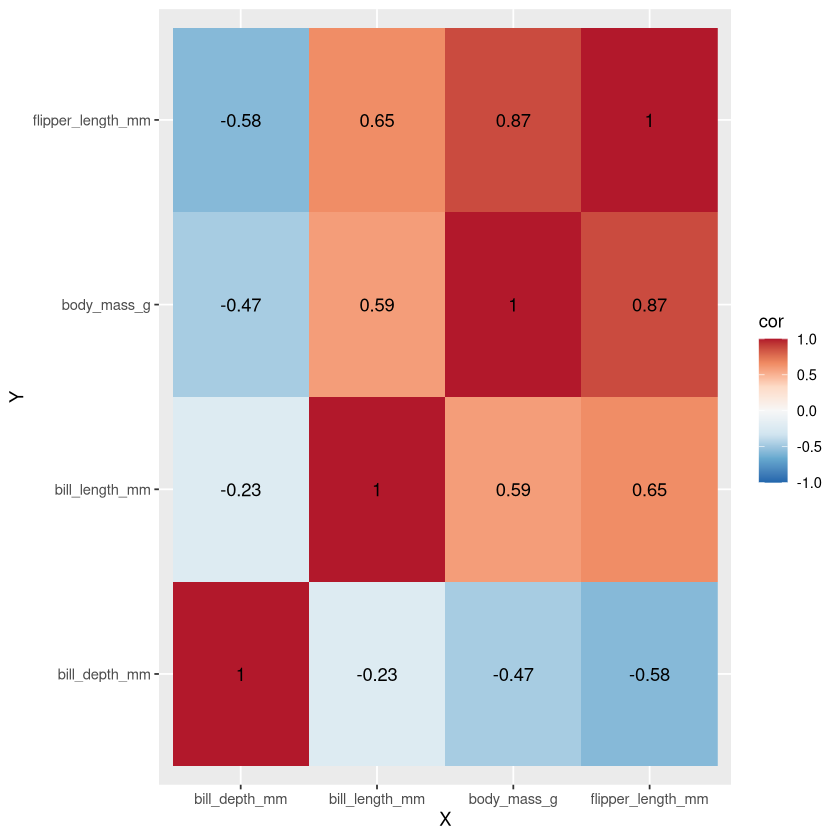

In [8]:
# - Plotting the numbers is easy with geom_text, but we need to round them
#   to get a readable result.
# - The "limits" argument for scale_... can be used to force the color scale
#   to go from -1 to +1.
ggplot(cortibble, aes(X, Y)) +
    geom_raster(aes(fill = cor)) +
    geom_text(aes(label = round(cor, 2))) +
    scale_fill_distiller(palette = "RdBu", limits=c(-1, 1))

# (Of course, this plot could be tweaked much further!)

- - - 

## Linear regression

We've already seen in Exercise 6 that we can _plot_ linear regressions easily via `geom_smooth()`. Now, let's see what actually happens under the hood and how we can compute and plot linear regressions explicitly. The techniques used here can be useful e.g. for making predictions with a regression model, and can be transferred to other, more complex models as well.

These exercises roughly follow [§23 "Model basics"](https://r4ds.had.co.nz/model-basics.html), although that chapter goes into a lot of detail about modelling beyond just the implementation in R, so I'll cherry-pick and refer you to individual parts of the chapter throughout.

**4. Compute a linear regression to predict `body_mass_g` from `flipper_length_mm`.** Could you write out the mathematical formula for this regression model? (_Note:_ Look at the help for `lm()`, the lecture slides, or the end of [§23.2](https://r4ds.had.co.nz/model-basics.html#a-simple-model) to get started here.)

In [9]:
(mod1 <- lm(body_mass_g ~ flipper_length_mm, data = penguins))


Call:
lm(formula = body_mass_g ~ flipper_length_mm, data = penguins)

Coefficients:
      (Intercept)  flipper_length_mm  
         -5872.09              50.15  


In [10]:
# Based on this, the regression is described by the formula
# y = -5872.09 + 50.15 * x

**5. Plot the points + the regression line following the technique in [§23.3](https://r4ds.had.co.nz/model-basics.html#visualising-models)!** In other words, make a data grid with model predictions, and recreate the following plot _without_ using `geom_smooth()`:

`geom_smooth()` using formula 'y ~ x'



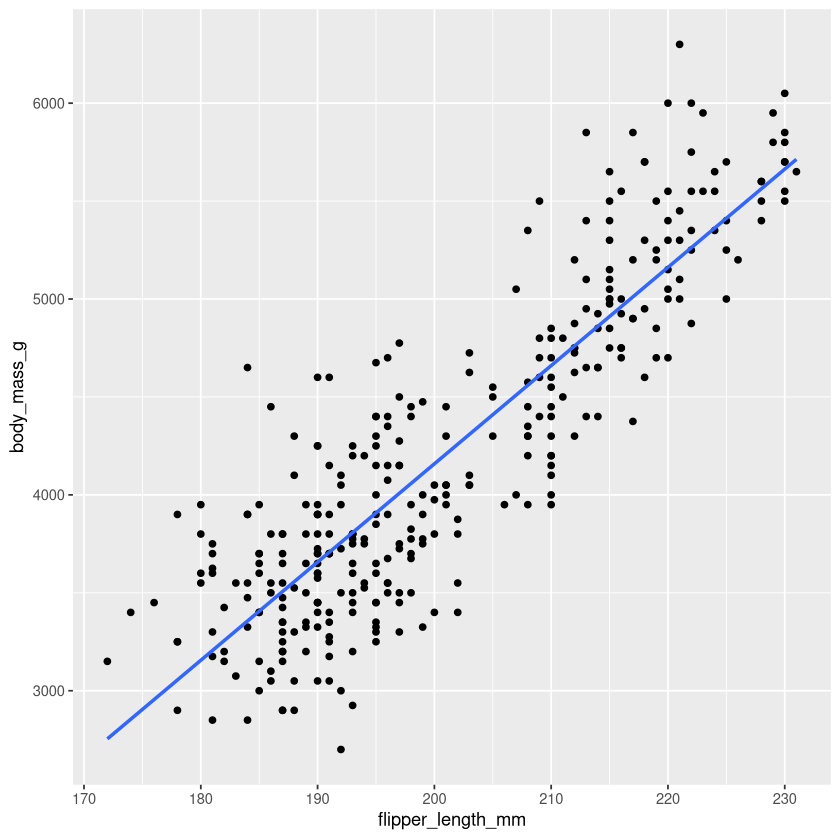

In [11]:
ggplot(penguins, aes(flipper_length_mm, body_mass_g)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE)

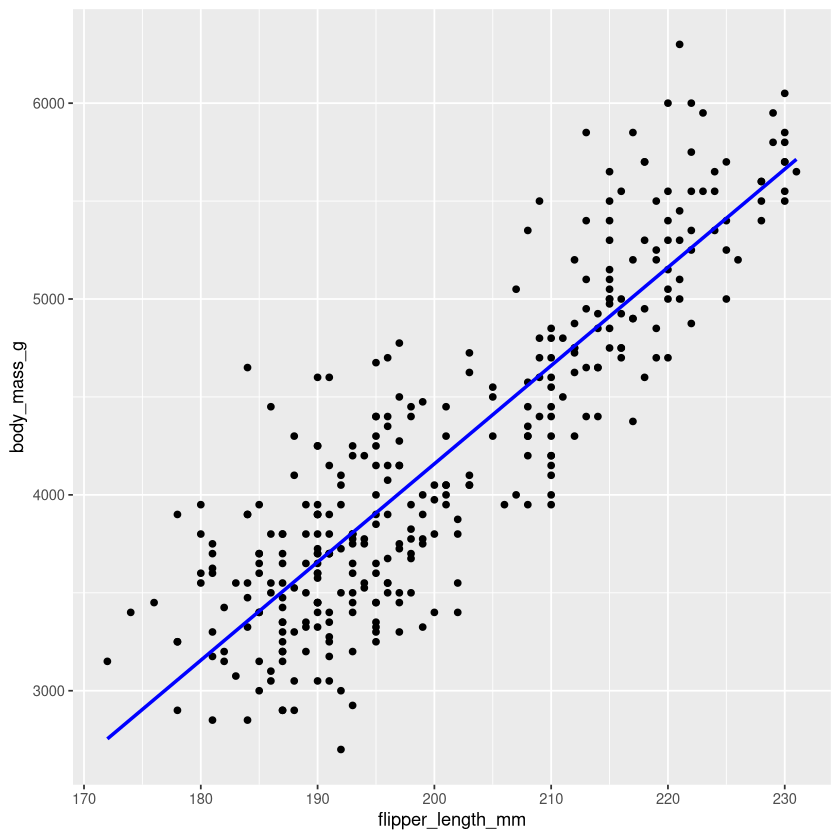

In [12]:
grid1 <- penguins %>%
    data_grid(flipper_length_mm) %>%
    add_predictions(mod1)

ggplot(penguins) +
  geom_point(aes(flipper_length_mm, body_mass_g)) +
  geom_line(aes(flipper_length_mm, pred), data = grid1, color = "blue", size = 1)

**6. Plot the _residuals_ of the regression from Q5!** This is also described in [§23.3](https://r4ds.had.co.nz/model-basics.html#visualising-models). Have you seen residuals before? Do you understand what they show? If not, look in the book & compare the residual plot with the plots from the previous task.

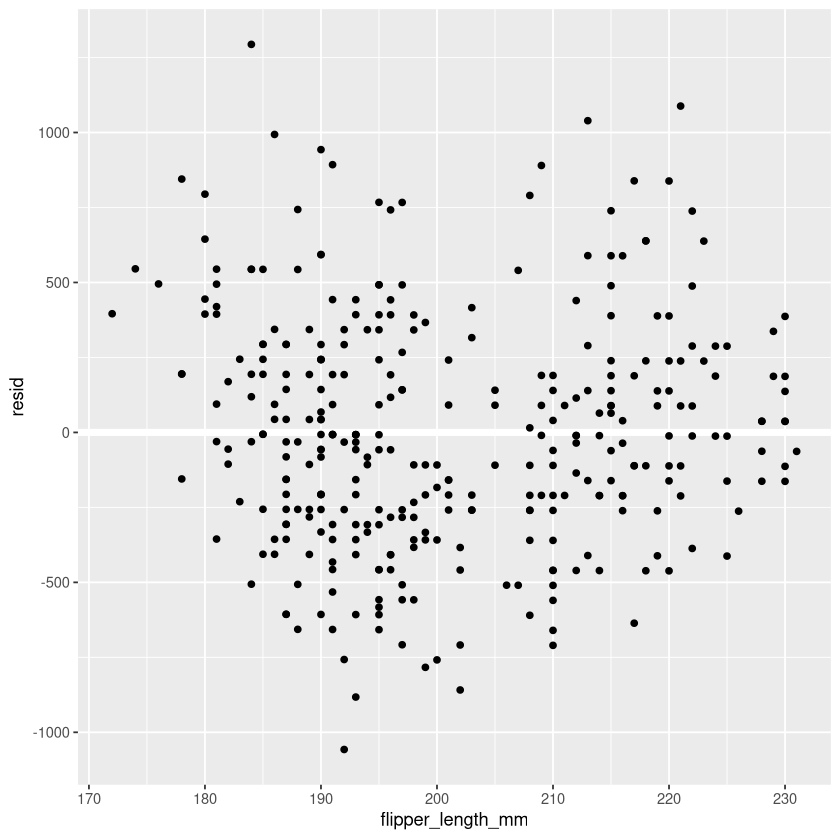

In [13]:
penguins %>%
    select(flipper_length_mm, body_mass_g) %>%
    add_residuals(mod1) %>%
    ggplot() +
        geom_ref_line(h = 0) +
        geom_point(aes(flipper_length_mm, resid))

# Residuals plot the _difference_ between the model predictions and the actual values.

**7. Compute linear regressions to predict `bill_depth_mm` from `bill_length_mm` _and_ `species`!** For this, we need to learn a bit about _formulas_ in R and how to use them to describe _interactions_ of variables. This is described in [§23.4](https://r4ds.had.co.nz/model-basics.html#formulas-and-model-families) of the book. Compute linear regression models that predict on `bill_length_mm` and `species` both _without interaction_ (via `+`) and _with interaction_ (via `*`), and show their coefficients.

In [14]:
(mod1 <- lm(bill_depth_mm ~ bill_length_mm + species, data = penguins))


Call:
lm(formula = bill_depth_mm ~ bill_length_mm + species, data = penguins)

Coefficients:
     (Intercept)    bill_length_mm  speciesChinstrap     speciesGentoo  
         10.5653            0.2004           -1.9331           -5.1033  


In [15]:
(mod2 <- lm(bill_depth_mm ~ bill_length_mm * species, data = penguins))


Call:
lm(formula = bill_depth_mm ~ bill_length_mm * species, data = penguins)

Coefficients:
                    (Intercept)                   bill_length_mm  
                       11.48771                          0.17668  
               speciesChinstrap                    speciesGentoo  
                       -3.91857                         -6.36675  
bill_length_mm:speciesChinstrap     bill_length_mm:speciesGentoo  
                        0.04553                          0.03093  


**8. Plot the points + regression lines for both models!** With `geom_smooth()`, we could produce this as follows:

`geom_smooth()` using formula 'y ~ x'



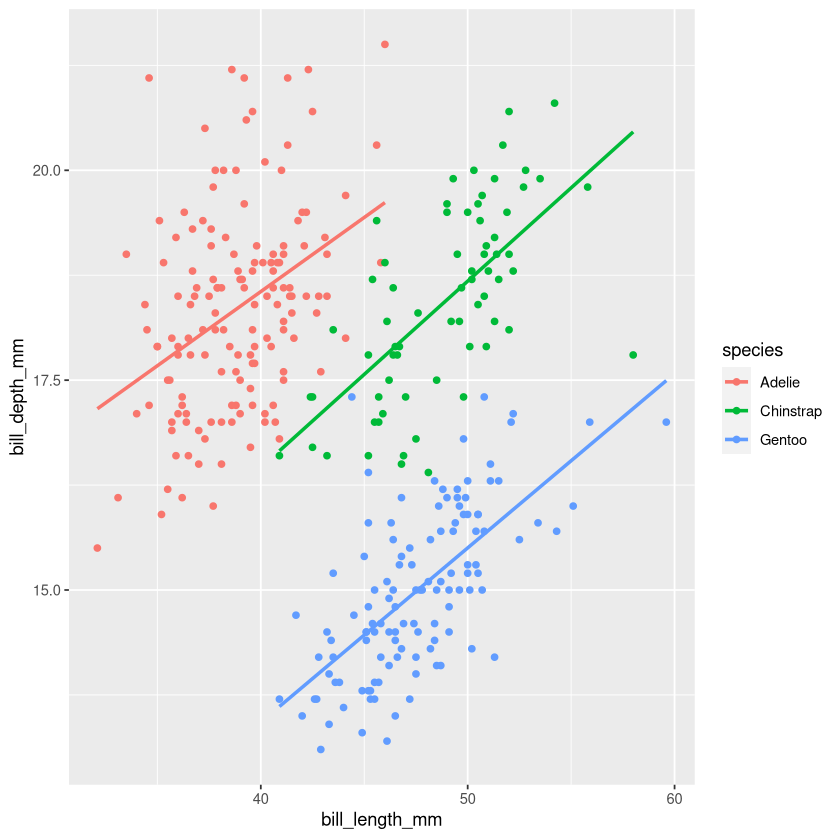

In [16]:
ggplot(penguins, aes(bill_length_mm, bill_depth_mm, color = species)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE)

But which formula is `geom_smooth()` using here? Are the regression lines equivalent to our models _with_ or _without_ interaction? Let's plot them explicitly to find out. (You can do separate plots for the two models, or you could even try to plot them in a single plot with different line styles!)

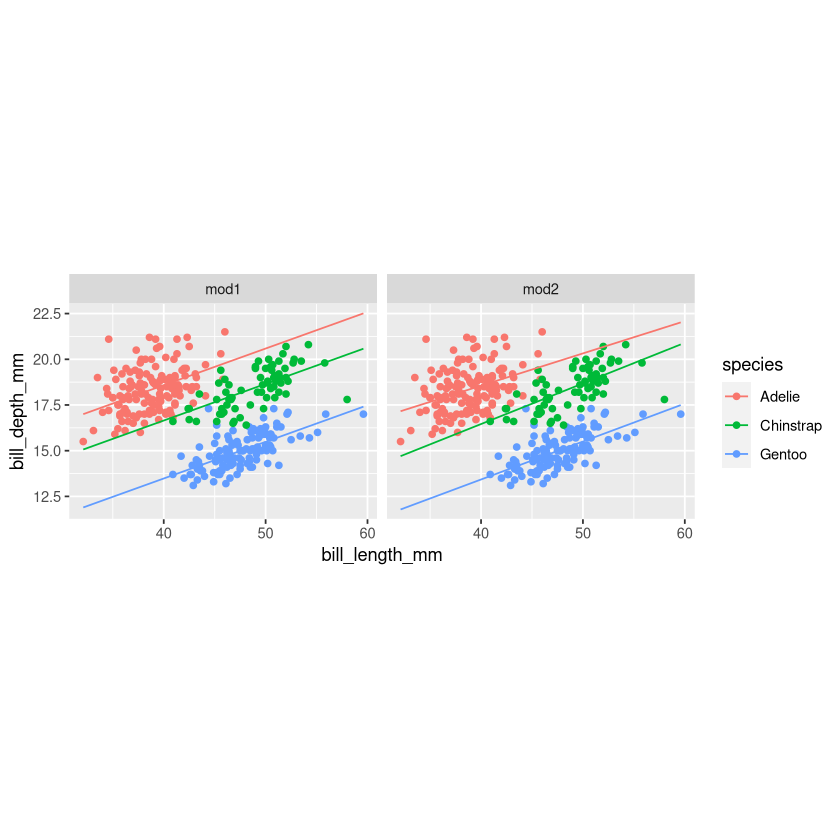

In [17]:
# The approach shown in the book:
penguins %>%
    data_grid(bill_length_mm, species) %>%
    gather_predictions(mod1, mod2) %>%
    ggplot(aes(x = bill_length_mm, color = species)) +
        geom_point(aes(y = bill_depth_mm), data = penguins) +
        geom_line(aes(y = pred)) +
        facet_wrap(~ model) +
        theme(aspect = .7)

# The difference is subtle here, but the plot from geom_smooth() corresponds
# to the model WITH interaction. You can also tell because the lines are not
# parallel, and this is only possible in a model WITH interaction.

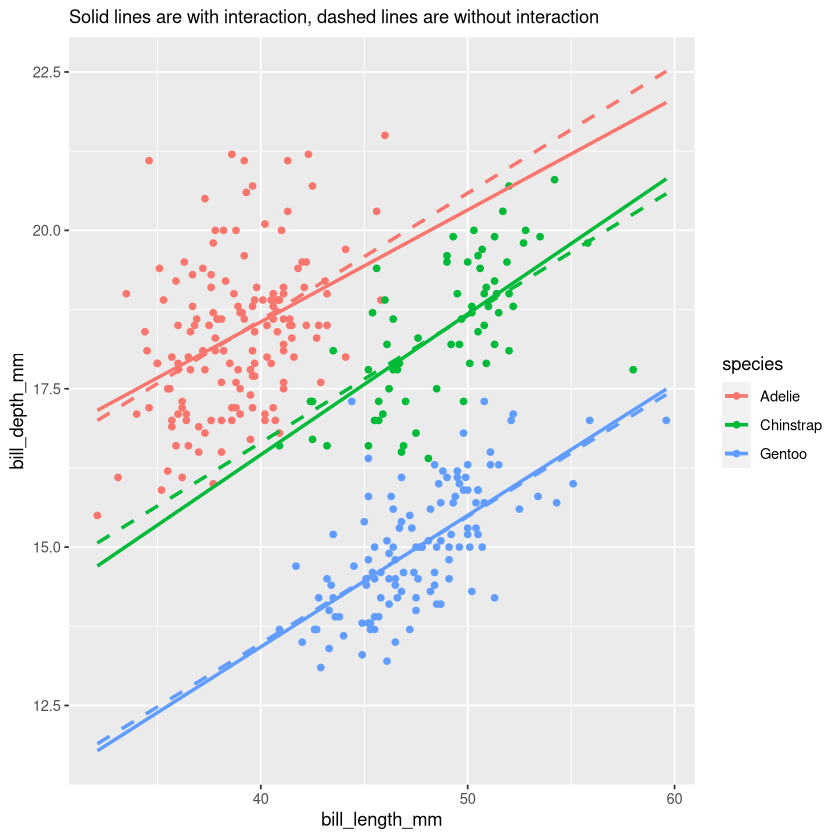

In [18]:
# An approach that plots both in a single plot:
penguins %>%
    data_grid(bill_length_mm, species) %>%
    add_predictions(mod1, var = "pred1") %>%
    add_predictions(mod2, var = "pred2") %>%
    ggplot(aes(x = bill_length_mm, color = species)) +
        geom_point(aes(y = bill_depth_mm), data = penguins) +
        geom_line(aes(y = pred1), linetype = 2, size = 1) +
        geom_line(aes(y = pred2), linetype = 1, size = 1) +
        labs(subtitle = "Solid lines are with interaction, dashed lines are without interaction")

**9. Plot the residuals for both models!** It's easiest to use the facet grid approach shown in the book.

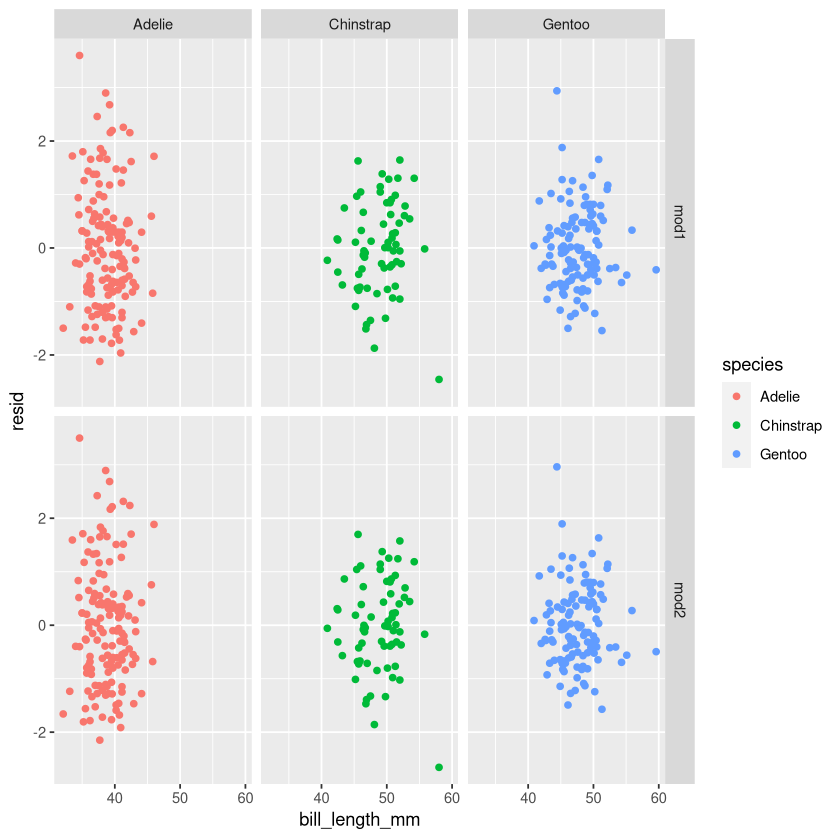

In [19]:
penguins %>%
    select(bill_length_mm, bill_depth_mm, species) %>%
    gather_residuals(mod1, mod2) %>%
    ggplot(aes(x = bill_length_mm, y = resid, color = species)) +
        geom_point() +
        facet_grid(model ~ species)

# It's hard to tell from this which model is better, because they're so similar.

- - -

## Tidymodels

What if we want to use different models than just linear regression? Traditionally, there are many different packages in the R ecosystem specializing in different kinds of models, which can make switching between models a bit tedious. [Tidymodels](https://www.tidymodels.org/) is a collection of packages that attempts to address this by providing a unified interface for model fitting, predicting, and evaluating (among other things).

We'll follow the ["Build a model" section from the "Getting started" guide](https://www.tidymodels.org/start/models/) in this section.

In [20]:
library(tidymodels)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 0.2.0 ──

✔ broom        0.8.0     ✔ rsample      0.1.1
✔ dials        0.1.1     ✔ tune         0.2.0
✔ infer        1.0.0     ✔ workflows    0.2.6
✔ modeldata    0.1.1     ✔ workflowsets 0.2.1
✔ parsnip      0.2.1     ✔ yardstick    0.0.9
✔ recipes      0.2.0     

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ broom::bootstrap() masks modelr::bootstrap()
✖ scales::discard()  masks purrr::discard()
✖ dplyr::filter()    masks stats::filter()
✖ recipes::fixed()   masks stringr::fixed()
✖ dplyr::lag()       masks stats::lag()
✖ yardstick::mae()   masks modelr::mae()
✖ yardstick::mape()  masks modelr::mape()
✖ yardstick::rmse

**10. Build and fit the linear regression model with interaction from Q7 (i.e., predict `bill_depth_mm` from `bill_length_mm * species`) with Tidymodels!** Basically, follow the "Build and fit a model" section of the guide, swapping out dataset and variables with ours. _(You don't need to produce the dot-and-whisker plot that relies on another package, but you can, of course.)_

In [21]:
lm_mod <- linear_reg()

In [22]:
(lm_fit <- lm_mod %>%
    fit(bill_depth_mm ~ bill_length_mm * species, data = penguins))

parsnip model object


Call:
stats::lm(formula = bill_depth_mm ~ bill_length_mm * species, 
    data = data)

Coefficients:
                    (Intercept)                   bill_length_mm  
                       11.48771                          0.17668  
               speciesChinstrap                    speciesGentoo  
                       -3.91857                         -6.36675  
bill_length_mm:speciesChinstrap     bill_length_mm:speciesGentoo  
                        0.04553                          0.03093  


In [23]:
tidy(lm_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),11.48770713,1.15987305,9.9042797,2.135979e-20
bill_length_mm,0.17668344,0.02980564,5.9278518,7.793199e-09
speciesChinstrap,-3.91856701,2.06730876,-1.8954919,5.890889e-02
speciesGentoo,-6.36675118,1.77989710,-3.5770333,4.000274e-04
bill_length_mm:speciesChinstrap,0.04552828,0.04594283,0.9909769,3.224296e-01
bill_length_mm:speciesGentoo,0.03092816,0.04111608,0.7522157,4.524625e-01


**11. Make predictions for all species given that the _bill length_ is 43mm, and plot the predictions with error bars!** Again, follow the guide.

In [24]:
new_points <- expand.grid(bill_length_mm = 43.0, species = unique(penguins$species))
# Note that instead of expand.grid(), we could also use exactly the same technique
# we used in the previous section, with data_grid().

(plot_data <- new_points %>%
     bind_cols(predict(lm_fit, new_data = new_points)) %>%
     bind_cols(predict(lm_fit, new_data = new_points, type = "conf_int"))
)

bill_length_mm,species,.pred,.pred_lower,.pred_upper
<dbl>,<fct>,<dbl>,<dbl>,<dbl>
43,Adelie,19.08510,18.79498,19.37521
43,Gentoo,14.04825,13.74088,14.35563
43,Chinstrap,17.12424,16.66275,17.58573


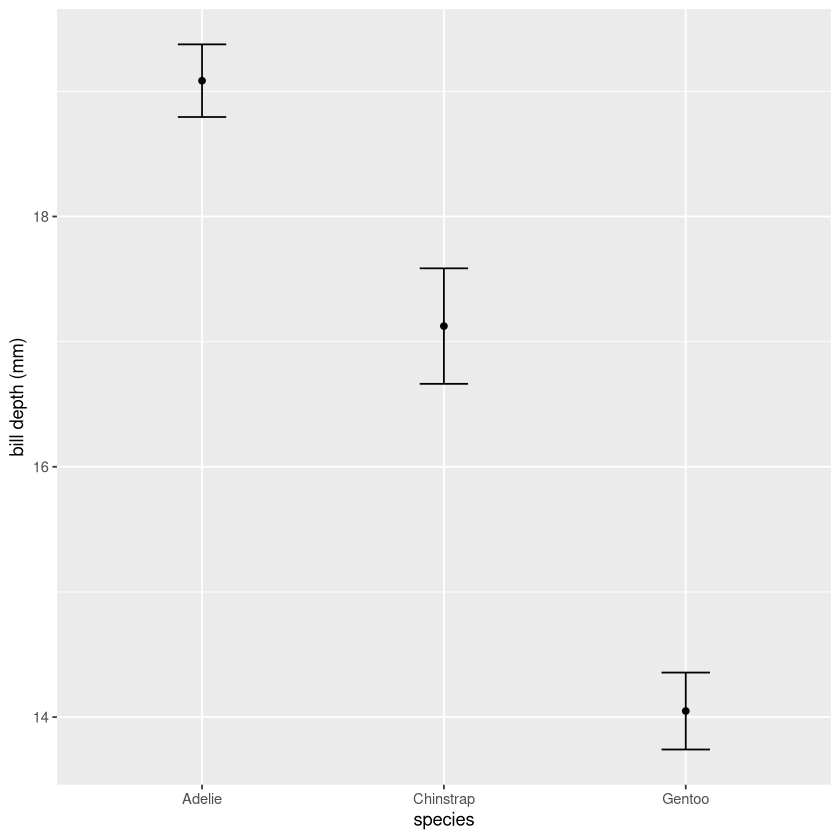

In [25]:
ggplot(plot_data, aes(x = species)) +
    geom_point(aes(y = .pred)) +
    geom_errorbar(aes(ymin = .pred_lower,
                      ymax = .pred_upper),
                  width = .2) +
    labs(y = "bill depth (mm)")

**12. What is the _root mean squared error (RMSE)_ of this linear regression model when evaluated with _10-fold cross-validation_?** In other words, let's start evaluating this model as a _predictive_ model and calculate some evaluation metrics. The ["Fit a Model with Resampling" section](https://www.tidymodels.org/start/resampling/#fit-resamples) describes how to do this; they're using a different dataset and a different classifier, but we perform exactly the same steps with our linear regression model.

Concretely, we need to:

- define our model via `workflow()` rather than calling `fit()` directly;
- split our penguins dataset into 10 separate folds; and
- fit this workflow on all the resampled folds.

(_Note:_ Tidymodels will automatically include RMSE as an evaluation metric for a regression task, no extra steps necessary for this...)

In [26]:
lm_wf <- workflow() %>%
    add_model(lm_mod) %>%
    add_formula(bill_depth_mm ~ bill_length_mm * species)

set.seed(123)
folds <- vfold_cv(penguins, v = 10)
lm_wf_rs <- fit_resamples(lm_wf, folds)

In [27]:
collect_metrics(lm_wf_rs)
# My model has an RMSE of ~0.96mm

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
rmse,standard,0.9585373,10,0.04068348,Preprocessor1_Model1
rsq,standard,0.7477359,10,0.03491944,Preprocessor1_Model1


**13. Fit a _random forest regressor_ and plot it similarly to Q8!** Let's try out how easily we can switch out one model for another with Tidymodels. If you have the `ranger` package installed, you can use the following lines to define a random forest regressor:

In [28]:
library(ranger)
(rf_mod <-
     rand_forest(mtry = 2, trees = 1000) %>%
     set_engine("ranger", importance = "impurity") %>%
     set_mode("regression"))

Random Forest Model Specification (regression)

Main Arguments:
  mtry = 2
  trees = 1000

Engine-Specific Arguments:
  importance = impurity

Computational engine: ranger 


The concept behind Tidymodels is that **you don't need to know how the `ranger` package works,** you can just use exactly the same Tidymodels functions to fit, predict, and evaluate as before.  Let's try it out, and combine what we've done in previous sections (before Tidymodels) with what we know now about the Tidymodels pipeline.  Concretely:

- Fit the `rf_mod` model to the data and produce a table with predictions. Note that you shouldn't use a single point this time (like in Q11), but make predictions for the entire range of values. (You can reuse `data_grid()` for that.)
- Produce a visualization similar to the one in Q8, plotting the random forest predictions as a line overlaid on the data points.

In [29]:
(rf_fit <- rf_mod %>% fit(bill_depth_mm ~ bill_length_mm * species, data = penguins))
# tidy() doesn't work here unfortunately

parsnip model object

Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, mtry = min_cols(~2,      x), num.trees = ~1000, importance = ~"impurity", num.threads = 1,      verbose = FALSE, seed = sample.int(10^5, 1)) 

Type:                             Regression 
Number of trees:                  1000 
Sample size:                      333 
Number of independent variables:  2 
Mtry:                             2 
Target node size:                 5 
Variable importance mode:         impurity 
Splitrule:                        variance 
OOB prediction error (MSE):       1.167945 
R squared (OOB):                  0.6988192 

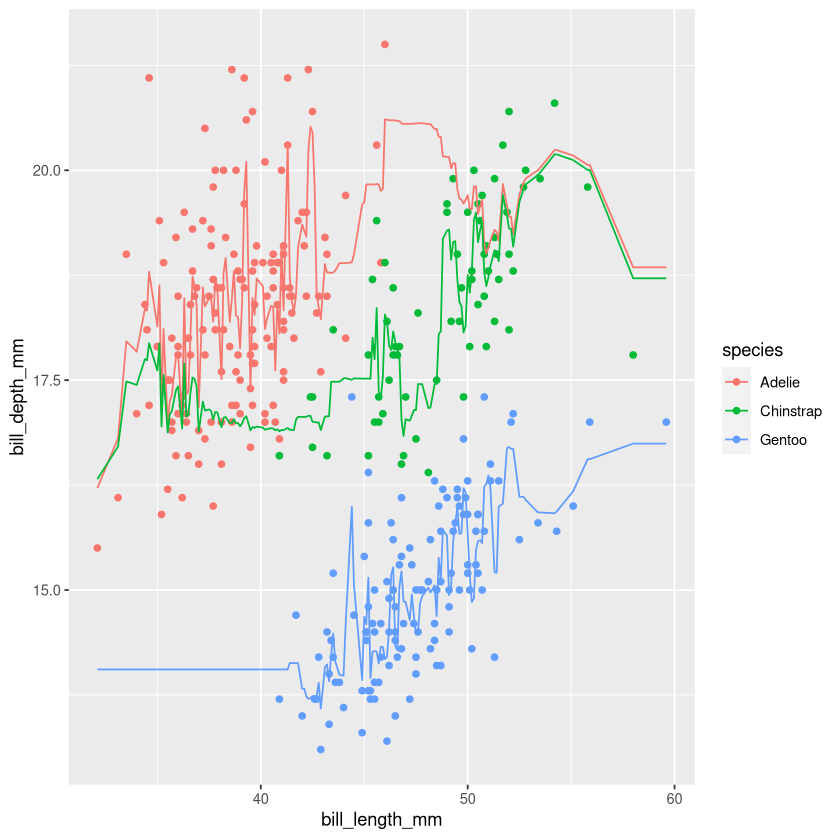

In [30]:
new_points <- data_grid(penguins, bill_length_mm, species)
plot_data <- new_points %>%
     bind_cols(predict(rf_fit, new_data = new_points))

ggplot(plot_data, aes(x = bill_length_mm, color = species)) +
    geom_point(aes(y = bill_depth_mm), data = penguins) +
    geom_line(aes(y = .pred))

# Overfitting much?

**14. What is the _root mean squared error (RMSE)_ of this random forest regression model when evaluated with _10-fold cross-validation_?** Is it better or worse than the linear regression model? You can do this analogously to Q12, with **one important caveat:** because we have an indicator variable in our formula, I need to import `library(hardhat)` and add `blueprint = default_formula_blueprint()` to the `add_formula(...)` call. (It's not important for us here why exactly this is needed.)

In [31]:
library(hardhat)


Attaching package: ‘hardhat’


The following object is masked from ‘package:modelr’:

    model_matrix




In [32]:
rf_wf <- workflow() %>%
    add_model(rf_mod) %>%
    add_formula(bill_depth_mm ~ species * bill_length_mm, blueprint = default_formula_blueprint())

set.seed(123)
folds <- vfold_cv(penguins, v = 10)
rf_wf_rs <- fit_resamples(rf_wf, folds)
collect_metrics(rf_wf_rs)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
rmse,standard,1.0041876,10,0.03151659,Preprocessor1_Model1
rsq,standard,0.7259108,10,0.02925274,Preprocessor1_Model1


You can use [many more models](https://parsnip.tidymodels.org/articles/Examples.html) with Tidyverse, even [neural networks](https://www.tidymodels.org/learn/models/parsnip-nnet/). If you're curious, try out more!



- - -

### What we've _not_ looked into

The Python exercise on statistical modeling covered several more advanced topics. Since R's modeling approach is so different from Python's in many respects, we focused more on the basics in this exercise, but here are some pointers that show how you could implement the other topics from the Python exercises as well.

- Statistical testing is a basic part of Tidymodels that we've not looked at. The ["Learn" section on the Tidymodels website](https://www.tidymodels.org/learn/) has several useful articles introducing this and other features.
- For feature importance, including _permutation feature importance_, look at the [vip package](https://koalaverse.github.io/vip/).
- [Dimensionality reduction](https://www.tmwr.org/dimensionality.html) is covered in the book [_Tidy Modeling with R_](https://www.tmwr.org/), which is, as the name suggests, another freely available resource that focuses entirely on Tidymodels.

For reference, here's a quick example with chi-square tests:

- Are the "species" and "sex" variables independent in our dataset? (Yes they are!)

In [33]:
chisq_test(penguins, species ~ sex)

statistic,chisq_df,p_value
<dbl>,<int>,<dbl>
0.04860717,2,0.9759894


- Are the "species" and "island" variables independent? (No they're not!)

In [34]:
chisq_test(penguins, species ~ island)

statistic,chisq_df,p_value
<dbl>,<int>,<dbl>
284.59,4,2.281892e-60
